In [160]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib import cm
import os, sys

import sys
sys.path.append("../scripts")

### Physical parameters for reference experiment

In [161]:
# environmental parameters
N = 1.e-3
f = 5.e-5
θ = 2.e-3

g = 9.81
α = 2.e-4
Λ = (N**2)/(g*α)
print(f"Λ = {Λ}")

# grid param
nx = 128
ny = 128
nz0 = 260

dx0 = 500
dy0 = 500
dz0 = 5
nz_vary_frac = 0.55

# mixing parameters
h = 250
k0 = 5.e-5
k1 = 5.e-3

Λ = 0.000509683995922528


### Intrinsic height and length scale

In [162]:
def Houter(h, k1, k0): return h*np.log(k1/k0)
def Ld(N, f, H): return N*H/f

Hdef = Houter(h, k1, k0)
δdef = calc_δ(N, θ, f, k1)
bbl = bbl_exp(k0, k1, h, N, f, θ, dz=dz_1d)
idx = bbl['z'] < Hdef
Nav = np.sqrt(np.mean(bbl['Bz'][:-1][idx]))
Ldef = Ld(Nav, f, Hdef)
print(fr"For default values, H = {round(Hdef)} m and Ld = {round(Ldef*1e-3,1)} km")

For default values, H = 1151 m and Ld = 8.9 km


### Parameter sweep


In [163]:
params = {
    "f": [0.5, 1, 2],
    "θ": [0.5, 2, 4, 8],
    "h": [0.5, 2],
    "k1": [0.5, 2],
}

defaults = {
    "f":f, "θ":θ, "h":h, "k1":k1
}

longnames = {"f":"f", "θ":"theta", "h":"h", "k1":"k1"}

#### Initialize with steady BBL solution


 /work/hfd/MITgcm/projects/bottom_mixing_layers/bml_f=x0.5/input/
19.96814727227246 1151 -3.406975665196688 18041.39101473318
nz=184 dx=1013

 /work/hfd/MITgcm/projects/bottom_mixing_layers/bml/input/
14.136498541002329 1151 -3.412586210232504 8904.908851060249
nz=260 dx=500

 /work/hfd/MITgcm/projects/bottom_mixing_layers/bml_f=x2/input/
9.999010246271597 1151 -3.413996328472465 4438.021119057401
nz=367 dx=249

 /work/hfd/MITgcm/projects/bottom_mixing_layers/bml_theta=x0.5/input/
14.14072529785507 1151 -3.4140504111656274 8874.936973368425
nz=259 dx=498

 /work/hfd/MITgcm/projects/bottom_mixing_layers/bml_theta=x2/input/
14.119654523413004 1151 -3.406859945280981 9023.099436618062
nz=260 dx=507

 /work/hfd/MITgcm/projects/bottom_mixing_layers/bml_theta=x4/input/
14.05326798300429 1151 -3.385832990872793 9470.713476551948
nz=261 dx=532

 /work/hfd/MITgcm/projects/bottom_mixing_layers/bml_theta=x8/input/
13.802452819466541 1151 -3.3227458862867687 10951.404048533559
nz=266 dx=615

 /wo

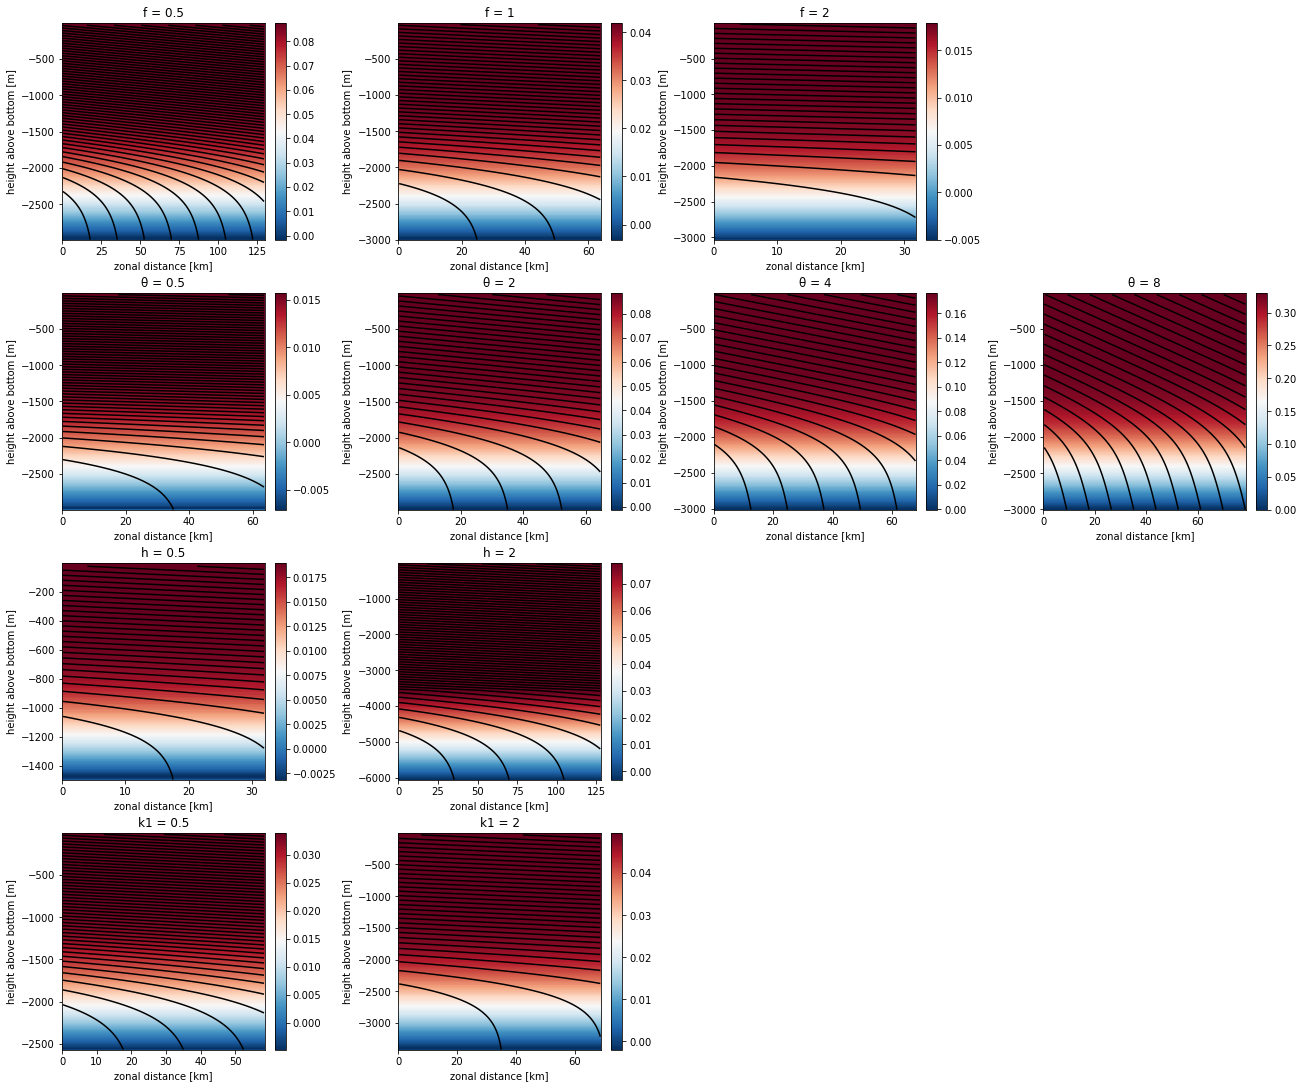

In [164]:
from bbl import *
dz_1d = 0.05

fig = plt.figure(figsize=(18, 15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)

for j, (k,v) in enumerate(params.items()):
    for i in range(len(v)):

        tmp = defaults.copy()
        tmp[k] *= v[i]

        # Generate topography
        Hbot = np.zeros_like(x[[0], :, :])
        Hbot = Hbot - (Hz - dz0)

        # Generate initial condition from steady BBL solutions
        δ = calc_δ(N, tmp["θ"], tmp["f"], tmp["k1"])
        #print("Check small parameter: δ/h = ", round(δ / tmp['h'], 5))
        bbl = bbl_exp(k0, tmp["k1"], tmp["h"], N, tmp["f"], tmp["θ"], dz=dz_1d)
        
        H = Houter(tmp["h"], tmp["k1"], k0)
        idx = bbl['z'] < H
        Nav = np.sqrt(np.mean(bbl['Bz'][:-1][idx]))
        L = Ld(Nav, tmp["f"], H)
        

        
        ## Vertical grid
        dz = dz0 * δ/δdef
        nz = np.int64(nz0 * H/Hdef * δdef/δ)
        nz_vary = np.int64(nz*nz_vary_frac)
        
        dz = dz * np.ones((nz))[:,np.newaxis,np.newaxis]*np.ones((nz,ny,nx))
        dz[nz_vary:,:,:] = dz[nz_vary,0,0]*(1. + 0.02 / (H/Hdef * δdef/δ))**np.arange(0,nz-nz_vary,1.0)[:,np.newaxis,np.newaxis]*np.ones((nz-nz_vary,ny,nx))
        Hz = sum(dz[:,0,0])

        dx = round(dx0 * L/Ldef)
        dy = round(dy0 * L/Ldef)
        
        Lx = nx*dx
        Ly = ny*dy
        
        x = np.arange(dx/2.0,Lx,dx)[np.newaxis,np.newaxis,:]*np.ones((nz,ny,nx))
        y = np.arange(dy/2.0,Ly,dy)[np.newaxis,:,np.newaxis]*np.ones((nz,ny,nx))
        z = (-Hz + np.cumsum(dz,axis=0) - dz/2.0)
        
        U = np.interp(z+Hz, bbl['z'], bbl['u'])
        V = np.interp(z+Hz, bbl['z'], bbl['v'])
        T = np.interp(z+Hz, bbl['z'], bbl['T'])

        T += np.random.normal(size=(nz, ny, nx),scale=1.e-8)/(g*α) # Callies2018 initial perturbation
        
        # generate 3D vertical eddy diffusivity field
        K = np.zeros((nz,ny,nx))
        for ii in range(nx):
            for jj in range(ny):
                K[:, jj, ii] = k0 + tmp["k1"]*np.exp(-(z[:,0,0] - Hbot[0,jj,ii])/tmp["h"])
        K[K>(tmp["k1"]+k0)] = tmp["k1"]+k0
        
        # save input data as binary files
        exp = f"_{longnames[k]}=x{v[i]}"
        if v[i]==1:
            exp = ""
        p = f"/work/hfd/MITgcm/projects/bottom_mixing_layers/bml{exp}/input/"
        print("\n", p)
        print(δ, round(H), np.log10(Nav), L)
        print(f"nz={nz}", f"dx={dx}")
        
        if ~os.path.exists("/".join(p.split("/")[0:-2])):
            os.system(f"mkdir -p {p}")
            
        # (Reverse vertical axis so first index is at the surface and transpose axes)
        newFile = open(p+"U.init", "wb")
        newFile.write(bytes(U[::-1,:,:].astype('>f8')))
        newFile.close()

        newFile = open(p+"V.init", "wb")
        newFile.write(bytes(V[::-1,:,:].astype('>f8')))
        newFile.close()

        newFile = open(p+"T.init", "wb")
        newFile.write(bytes(T[::-1,:,:].astype('>f8')))
        newFile.close()

        newFile = open(p+"kappa.init", "wb")
        newFile.write(bytes(K[::-1,:,:].astype('>f8')))
        newFile.close()

        newFile = open(p+"topog.init", "wb")
        newFile.write(bytes(Hbot[0,:,:].astype('>f8')))
        newFile.close()

        newFile = open(p+"delZ.init", "wb")
        newFile.write(bytes(dz[::-1,:,:][:,0,0].astype('>f8')))
        newFile.close()
        
        ax = fig.add_subplot(spec[j, i])
        pc = ax.pcolor(x[:,0,:]*1e-3,z[:,0,:],V[:,ny//2,:], shading='auto', cmap="RdBu_r")
        cb = plt.colorbar(pc)
        Ttot = (T + Λ*(z*np.cos(tmp["θ"]) + x*np.sin(tmp["θ"])))
        ax.contour(x[:,0,:]*1e-3,z[:,0,:],Ttot[:,ny//2,:],
                    colors="k", levels=np.arange(np.min(Ttot[:,ny//2,:]), np.max(Ttot[:,ny//2,:]), 0.025*np.sqrt(v[i])), linestyles="solid")
        ax.set_xlabel('zonal distance [km]')
        ax.set_ylabel('height above bottom [m]')
        ax.set_title(f"{k} = {v[i]}")

plt.show()